In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
import plotnine as p9

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [35]:
print(
    '#rows: {}, #cols: {}, year range: {} - {}'.format(
        df.shape[0], df.shape[1], df['YrSold'].min(), df['YrSold'].max()
    )
)

#rows: 1460, #cols: 80, year range: 2006 - 2010


# 1. Missing Values

* We first go through the columns with missing values and try to understand the reason of missing
* Then we pre-process the missing values by removing columns or rows or 

## 1.1 Get the percentage of NA values for each column

Only show the columns that have NA values

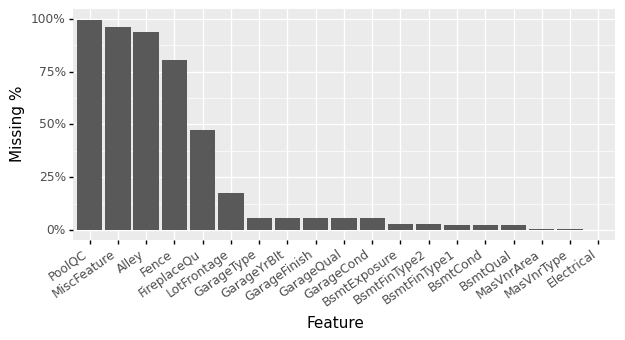

<ggplot: (8733965987560)>

In [4]:
na_freq = df.apply(lambda x: sum(x.isna()) / len(x), axis=0)
na_freq = (
    na_freq[na_freq>0]
    .reset_index()
    .rename(columns={'index': 'Feature', 0: 'Missing %'})
    .sort_values(by='Missing %', ascending=False)
)
na_freq['Feature'] = pd.Categorical(na_freq['Feature'], categories=na_freq['Feature'].tolist())
(
    p9.ggplot(na_freq, p9.aes('Feature', 'Missing %'))
    + p9.geom_bar(stat='identity')
    + p9.scale_y_continuous(labels=lambda x: ["{:.0%}".format(v) for v in x])
    + p9.theme(
        axis_text_x = p9.element_text(angle=35,hjust=1),
        figure_size = (7, 3)
    )
)

In [5]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
print(sorted(df['Neighborhood'].unique()))

['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']


## 1.2 Find the reason for missing: missing at random, or missing for a reason

* Missing because the component does not exist in the house:
    * PoolQC
    * MiscFeature
    * Alley
    * Fence
    * FireplaceQu
    * GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond
    * BsmtExposure (NA and "No" have different meaning)
    * BsmtFinType1, BsmtFinType2, BsmtCond, BsmtQual
    
    
* Missing at random
    * LotFrontage
    * MasVnrType & MasVnrArea
    * Electrical


### 1.2.1 Example of missing due to non-existance of a house component

In [7]:
# Define two helper functions for calculating percentiles
def q05(x):
    return np.quantile(x, 0.05)
def q95(x):
    return np.quantile(x, 0.95)

In [8]:
# When there is no pool (PoolArea == 0), PoolQC is missing
(
    df.groupby('PoolQC', dropna=False)
    .agg({
        'PoolArea': [q05, np.median, q95],
        'SalePrice': [q05, np.median, q95]
    })
)

PoolArea                SalePrice                    
            q05 median     q95       q05    median       q95
PoolQC                                                      
Ex       514.15  533.5  552.85  260500.0  490000.0  719500.0
Fa       525.45  583.5  641.55  184450.0  215500.0  246550.0
Gd       489.60  576.0  721.80  161100.0  171000.0  264573.0
NaN        0.00    0.0    0.00   88000.0  162900.0  325774.4

### 1.2.2 Confirm missing at random

In [9]:
# LotFrontage:
# Missing vs non-missing: similar sale price and year built
#    (although there are some difference in median sale price)
# So we consider this as missing at random
# Consider removing this column
# Since this column is highly correlated with LotArea, we may consider removing this feature.

(
    df.groupby(df['LotFrontage'].isna())
    .agg({
        'LotFrontage': [len, q05, np.median, q95],
        'SalePrice': [q05, np.median, q95],
        'YearBuilt': [q05, np.median, q95],
        'LotArea': [q05, np.median, q95],
        'LotShape': lambda x: x.value_counts()
    })
)

LotFrontage                     SalePrice                      \
                    len   q05 median    q95       q05    median       q95   
LotFrontage                                                                 
False              1201  34.0   69.0  107.0   87000.0  159500.0  337500.0   
True                259   NaN    NaN    NaN  107900.0  172400.0  278000.0   

            YearBuilt                 LotArea                    \
                  q05  median     q95     q05   median      q95   
LotFrontage                                                       
False          1915.0  1972.0  2007.0  3230.0   9262.0  16226.0   
True           1930.9  1976.0  2003.0  4357.7  10624.0  24747.7   

                      LotShape  
                      <lambda>  
LotFrontage                     
False        [851, 317, 26, 7]  
True          [167, 74, 15, 3]

/home/ye/.local/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 293 rows containing missing values.


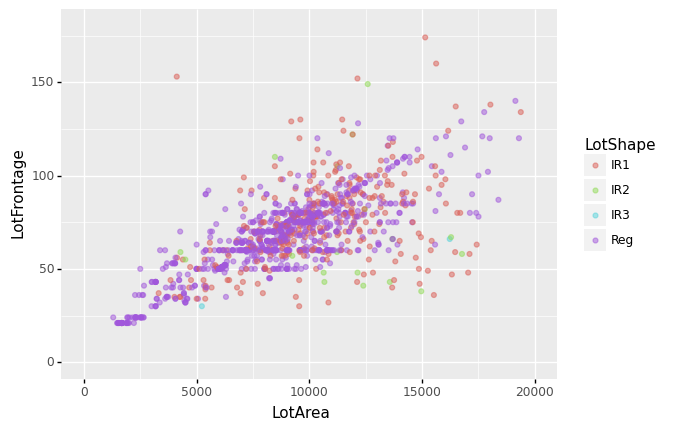

<ggplot: (8733953396574)>

In [10]:
(
    p9.ggplot(df, p9.aes('LotArea', 'LotFrontage', color='LotShape'))
    + p9.geom_point(alpha=0.5)
    + p9.xlim(0, 20000)
    + p9.ylim(0, 180)
)

In [11]:
# MasVnrType and MasVnrArea

# When MasVnrType is missing, the corresponding MasVnrArea value is also missing
# No systematic difference in the values in year_built and neighborhood
#    between MasVnrType missing and non-missing groups

# Fill in "None" and "0" for Type and Area, because that is the most observed values

(
    df.groupby('MasVnrType', dropna=False)
    .agg({
        'MasVnrArea': [len, q05, np.median, q95],
        'SalePrice': np.median,
        'YearBuilt': [q05, np.median, q95],
        'Neighborhood': lambda x: x.unique()
    })
)

MasVnrArea                      SalePrice YearBuilt          \
                  len   q05 median     q95    median       q05  median   
MasVnrType                                                               
BrkCmn             15  58.5  192.0  530.00  139000.0   1946.10  1961.0   
BrkFace           445  40.0  202.0  652.60  181000.0   1955.00  1988.0   
None              864   0.0    0.0    0.00  143000.0   1910.00  1961.0   
Stone             128  50.0  206.5  614.45  246839.0   1957.70  2006.0   
NaN                 8   NaN    NaN     NaN  203287.0   1972.75  2004.5   

                                                         Neighborhood  
               q95                                           <lambda>  
MasVnrType                                                             
BrkCmn      1969.6         [NAmes, ClearCr, BrkSide, OldTown, Sawyer]  
BrkFace     2006.0  [CollgCr, NoRidge, NAmes, NridgHt, Somerst, St...  
None        2006.0  [Veenker, Crawfor, Mitchel, OldTown, BrkSide, ...  
Stone       2009.0  [Somerst, NWAmes, NridgHt, CollgCr, Edwards, N...  
NaN         2007.0  [Gilbert, Crawfor, Somerst, SawyerW, NridgHt, ...

In [12]:
(
    df.groupby(df['MasVnrType'].isna())
    .agg({
        'MasVnrArea': [len, q05, np.median, q95],
        'SalePrice': np.median,
        'YearBuilt': [q05, np.median, q95],
        'Neighborhood': lambda x: x.unique()
    })
)

MasVnrArea                    SalePrice YearBuilt                  \
                  len  q05 median    q95    median       q05  median     q95   
MasVnrType                                                                     
False            1452  0.0    0.0  456.0  162700.0   1916.00  1972.0  2007.0   
True                8  NaN    NaN    NaN  203287.0   1972.75  2004.5  2007.0   

                                                 Neighborhood  
                                                     <lambda>  
MasVnrType                                                     
False       [CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...  
True        [Gilbert, Crawfor, Somerst, SawyerW, NridgHt, ...

In [13]:
# Electrical

# There is only one missing data for the column "Electrical"
# And the "Utilities" column says it has all utilities.

# Since only one row, it's safe to remove this data

df[df['Electrical'].isna()]['Utilities']

1379    AllPub
Name: Utilities, dtype: object

## 1.3 Pre-process the missing values

In [14]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [15]:
categorical_feats = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtExposure', 'BsmtCond', 'BsmtQual'
]
# 'GarageYrBlt'

In [16]:
df['GarageYrBlt'].fillna(0, inplace=True)

In [17]:
df[categorical_feats] = df[categorical_feats].fillna('Not exist')

In [18]:
sel = df['BsmtFinType1'].isna() & df['BsmtFinType2'].isna()
df.loc[sel, 'BsmtFinType1'] = 'Not exist'
df.loc[sel, 'BsmtFinType2'] = 'Not exist'
df.loc[df['BsmtFinType2'].isna(), 'BsmtFinType2'] = 'Unf'

In [19]:
df = df.drop(columns='LotFrontage')

In [20]:
df.loc[df['MasVnrType'].isna(), 'MasVnrType'] = 'None'

In [21]:
df.loc[df['MasVnrArea'].isna(), 'MasVnrArea'] = 0

<AxesSubplot:>

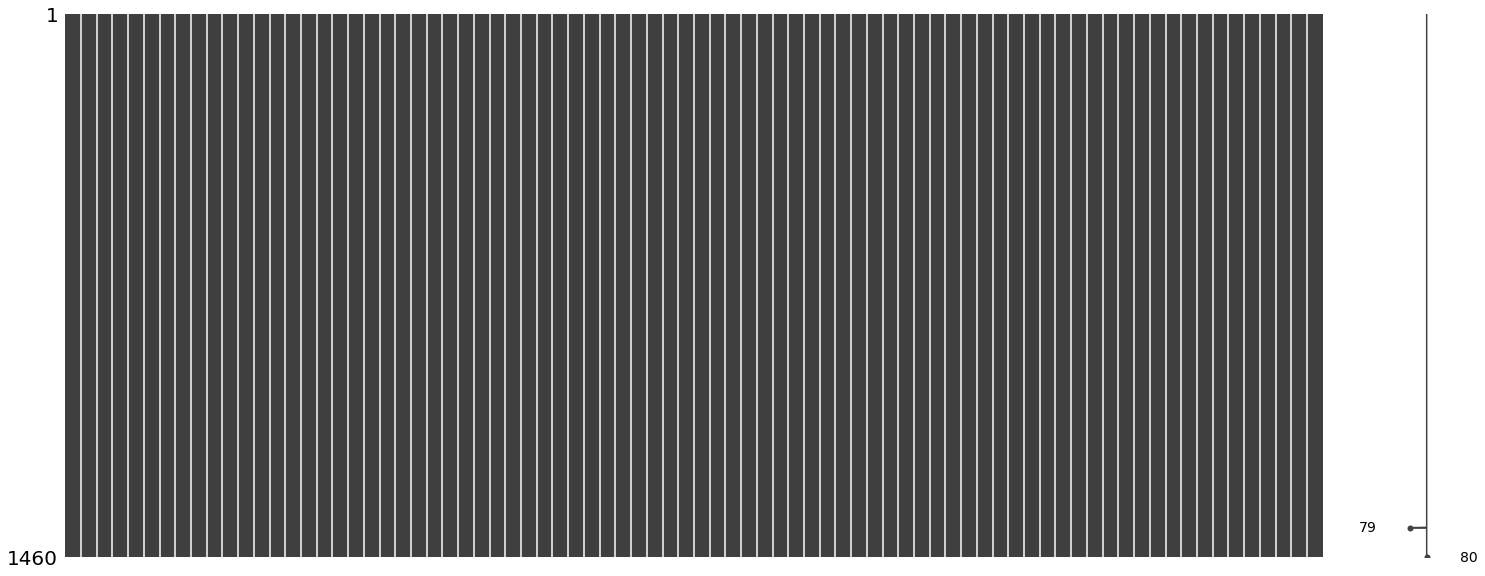

In [22]:
# After process missing values
msno.matrix(df)

In [23]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

# 2. Outliers

<AxesSubplot:>

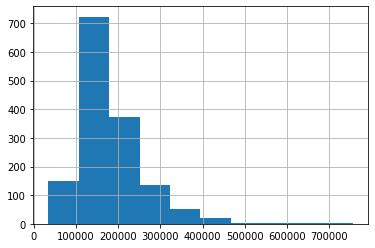

In [24]:
df['SalePrice'].hist()

In [25]:
df.sort_values(by='SalePrice', ascending=False)

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,21535,Pave,Not exist,IR1,Lvl,AllPub,Corner,...,0,Not exist,Not exist,Not exist,0,1,2007,WD,Normal,755000
1182,1183,60,RL,15623,Pave,Not exist,IR1,Lvl,AllPub,Corner,...,555,Ex,MnPrv,Not exist,0,7,2007,WD,Abnorml,745000
1169,1170,60,RL,35760,Pave,Not exist,IR1,Lvl,AllPub,CulDSac,...,0,Not exist,Not exist,Not exist,0,7,2006,WD,Normal,625000
898,899,20,RL,12919,Pave,Not exist,IR1,Lvl,AllPub,Inside,...,0,Not exist,Not exist,Not exist,0,3,2010,New,Partial,611657
803,804,60,RL,13891,Pave,Not exist,Reg,Lvl,AllPub,Inside,...,0,Not exist,Not exist,Not exist,0,1,2009,New,Partial,582933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,31,70,C (all),8500,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,Not exist,MnPrv,Not exist,0,7,2008,WD,Normal,40000
533,534,20,RL,5000,Pave,Not exist,Reg,Low,AllPub,Inside,...,0,Not exist,Not exist,Not exist,0,1,2007,WD,Normal,39300
968,969,50,RM,5925,Pave,Not exist,Reg,Lvl,AllPub,Inside,...,0,Not exist,GdWo,Not exist,0,5,2009,WD,Abnorml,37900
916,917,20,C (all),9000,Pave,Not exist,Reg,Lvl,AllPub,Inside,...,0,Not exist,Not exist,Not exist,0,10,2006,WD,Abnorml,35311


# 3. Categorical variable encoding

In [26]:
(
    df.groupby(['YrSold', 'Neighborhood'])
    .agg({'SalePrice': np.mean})
    .reset_index()
    .pivot(index='Neighborhood', columns='YrSold')
).style.format('{:.0f}')

In [27]:
num_to_categorical_feats = ['MSSubClass', 'OverallQual', 'OverallCond', 'YrSold']
for col in num_to_categorical_feats:
    df[col] = df[col].astype(str)

basement_feats = set(['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2'])
feats_to_combine = set(['Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd'])
one_hot_feats = set(df.dtypes[df.dtypes == 'object'].index) - basement_feats - feats_to_combine

In [32]:
# basement_feats contains two categorical and two numerical
print(
    'Number of categorical features: ',
    len(one_hot_feats) + len(feats_to_combine) + len(basement_feats) / 2
)

Number of categorical features:  47.0


In [28]:
(sum(df['BsmtFinSF1'] == 0), sum(df['BsmtFinSF2'] == 0))

(467, 1293)

In [28]:
# df = pd.get_dummies(df, columns=one_hot_feats, drop_first=True, dummy_na=True)
df = pd.get_dummies(df, columns=one_hot_feats, drop_first=True)

In [29]:
basement_type = set(df['BsmtFinType1'].unique()).union(set(df['BsmtFinType2'].unique()))
# add columns to df
for bt in basement_type:
    df['BsmtFinSF_' + bt] = 0

# fill in square feet values into the columns
for r in range(len(df)):
    col = 'BsmtFinSF_' + df.loc[r, 'BsmtFinType1']
    if df.loc[r, 'BsmtFinType1'] == 'Not exist':
        df.loc[r, col] = 1
    else:
        df.loc[r, col] = df.loc[r, 'BsmtFinSF1']
    
    # Fill in the number for the second BsmtFinType.
    col = 'BsmtFinSF_' + df.loc[r, 'BsmtFinType2']
    if df.loc[r, 'BsmtFinType2'] == 'Not exist':
        df.loc[r, col] = 1
    else:
        # If the col is the same as the prev col, we just add the numbers together.
        df.loc[r, col] += df.loc[r, 'BsmtFinSF2']
    

In [30]:
def combine_features(df, feat1, feat2, feat_prefix):
    feat_levels = set(df[feat1].unique()).union(set(df[feat2].unique()))
    print('Feature levels = ', feat_levels)
    # create new columns for each level of the feature
    # and initialize to all 0's
    for l in feat_levels:
        df[feat_prefix + l] = '0'
    
    # fill in value 1 to the relevant columns
    for r in range(len(df)):
        col = feat_prefix + df.loc[r, feat1]
        df.loc[r, col] = '1'
        col = feat_prefix + df.loc[r, feat2]
        df.loc[r, col] = '1'
        
    return df

In [31]:
wrong_spelling = {'Wd Shng': 'Wd Sdng', 'CmentBd': 'CemntBd'}
df['Exterior1st'].replace(wrong_spelling, inplace=True)
df['Exterior2nd'].replace(wrong_spelling, inplace=True)

In [32]:
df = combine_features(df, 'Condition1', 'Condition2', 'Condition_')
df = combine_features(df, 'Exterior1st', 'Exterior2nd', 'Exterior_')

Feature levels =  {'Feedr', 'RRAn', 'RRNe', 'RRNn', 'PosN', 'Artery', 'RRAe', 'Norm', 'PosA'}
Feature levels =  {'BrkComm', 'Stucco', 'CBlock', 'BrkFace', 'Plywood', 'Wd Sdng', 'CemntBd', 'MetalSd', 'Other', 'VinylSd', 'Brk Cmn', 'AsphShn', 'AsbShng', 'Stone', 'HdBoard', 'ImStucc', 'WdShing'}


In [33]:
# Check the feature transformed result
df[['BsmtFinSF_ALQ', 'BsmtFinSF_Rec', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2']].tail(6)

,BsmtFinSF_ALQ,BsmtFinSF_Rec,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2
1454,0,0,GLQ,410,Unf,0
1455,0,0,Unf,0,Unf,0
1456,790,163,ALQ,790,Rec,163
1457,0,0,GLQ,275,Unf,0
1458,0,1029,GLQ,49,Rec,1029
1459,0,0,BLQ,830,LwQ,290


In [34]:
df['Condition_Feedr'].head(5)

0    0
1    1
2    0
3    0
4    0
Name: Condition_Feedr, dtype: object

In [35]:
df.head()

,Id,LotArea,Condition1,Condition2,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrArea,BsmtFinType1,...,Exterior_MetalSd,Exterior_Other,Exterior_VinylSd,Exterior_Brk Cmn,Exterior_AsphShn,Exterior_AsbShng,Exterior_Stone,Exterior_HdBoard,Exterior_ImStucc,Exterior_WdShing
0,1,8450,Norm,Norm,2003,2003,VinylSd,VinylSd,196.0,GLQ,...,0,0,1,0,0,0,0,0,0,0
1,2,9600,Feedr,Norm,1976,1976,MetalSd,MetalSd,0.0,ALQ,...,1,0,0,0,0,0,0,0,0,0
2,3,11250,Norm,Norm,2001,2002,VinylSd,VinylSd,162.0,GLQ,...,0,0,1,0,0,0,0,0,0,0
3,4,9550,Norm,Norm,1915,1970,Wd Sdng,Wd Sdng,0.0,ALQ,...,0,0,0,0,0,0,0,0,0,0
4,5,14260,Norm,Norm,2000,2000,VinylSd,VinylSd,350.0,GLQ,...,0,0,1,0,0,0,0,0,0,0


In [147]:
df[['Condition1', 'Condition2']].iloc[[974, 1003, 88]]

,Condition1,Condition2
974,RRAn,Feedr
1003,Feedr,RRAn
88,Feedr,Feedr


In [165]:
dummy_example_df = pd.get_dummies(
    df[['Condition1', 'Condition2']].iloc[[974, 1003, 88]])

dummy_example2_df = pd.concat([
    dummy_example_df['Condition1_Feedr'] | dummy_example_df['Condition2_Feedr'],
    dummy_example_df['Condition1_RRAn'] | dummy_example_df['Condition2_RRAn']
], axis=1).rename(columns={0: 'Condition_Feedr', 1: 'Condition_RRAn'})

Text(0.5, 1.0, '(b) Two-hot Encoding')

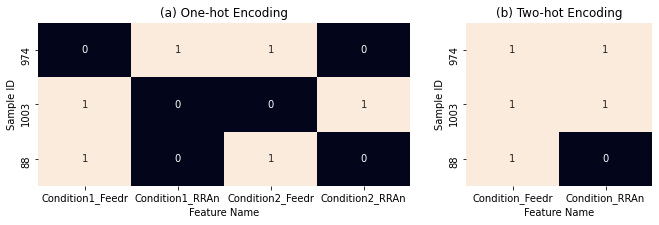

In [187]:

fig, ax = plt.subplots(1, 2, figsize=(11,3), gridspec_kw={'width_ratios': [2, 1]})

sns.heatmap(dummy_example_df, annot=True, cbar=False, ax=ax[0])
sns.heatmap(dummy_example2_df, annot=True, cbar=False, ax=ax[1])

for i in range(2):
    ax[i].set_ylabel('Sample ID')
    ax[i].set_xlabel('Feature Name')
    # ax[i].xticks(rotation=10)

ax[0].set_title('(a) One-hot Encoding')
ax[1].set_title('(b) Two-hot Encoding')


In [36]:
# Categorical vs Numerical

# Looks like numerical, but should be categorical
# MSSubClass, OverallQual, OverallCond

# YrSold: Categorical
# Numerical : MoSold

# Two-hot encoding - combine two columns by using OR operator first
# Condition1, Condition2
# Exterior1st, Exterior2nd

# One-hot encoding for BsmtFinType - do not remove first level
# Fill in actual SF into the corresponding column
# BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2

# All other columns of the "object" type ---> categorical

# All remaining columns: numerical

# 4. Add nonlinearity

In [37]:
df['MoSold_sq'] = df['MoSold'] ** 2

In [38]:
df['YearBuilt_sq'] = (df['YearBuilt'] - 1850) ** 2

In [39]:
pd.DataFrame({'col': df.columns, 'type': list(df.dtypes)}).head(5)

,col,type
0,Id,int64
1,LotArea,int64
2,Condition1,object
3,Condition2,object
4,YearBuilt,int64


In [56]:
# MoSold vs SalePrice: nonlinear relation, some quadratic transformation may be useful here.
# df_plot = df.groupby(['YrSold', 'MoSold']).agg({'SalePrice': np.median}).reset_index()
# df_plot['YrSold'] = df_plot['YrSold'].astype(str)
# p9.ggplot(df_plot, p9.aes(x='MoSold', y='SalePrice', group='YrSold', color='YrSold')) + p9.geom_line()

In [55]:
# Some years have lower price. But the relation is not simple.
# Consider it as categorical and let the algorithm decide the impact of this feature to the price.
# p9.ggplot(df, p9.aes(x='YrSold', y='SalePrice', group='YrSold')) + p9.geom_boxplot() + p9.ylim(100000, 300000)

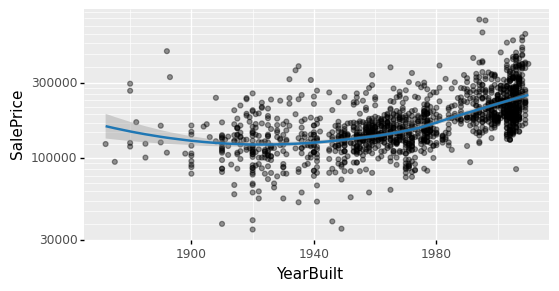

<ggplot: (8733948869678)>

In [54]:
# YearBuilt: nonlinear relation
(
    p9.ggplot(df, p9.aes(x='YearBuilt', y='SalePrice'))
    + p9.geom_point(alpha=0.4)
    + p9.scale_y_log10()
    + p9.geom_smooth(method='loess', color='tab:blue')
    + p9.theme(figure_size=(6, 3))
)

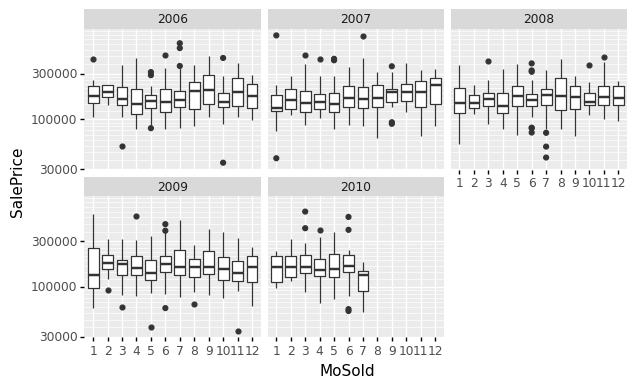

<ggplot: (8733948836714)>

In [68]:
# MoSold: nonlinear relation
(
    p9.ggplot(df, p9.aes(x='MoSold', y='SalePrice', group='MoSold'))
    + p9.geom_boxplot()
    + p9.scale_y_log10()
    + p9.scale_x_discrete(limits=np.arange(1,13))
    # + p9.geom_smooth(method='loess', color='tab:blue')
    + p9.theme(figure_size=(7, 4)) + p9.facet_wrap('~ YrSold')
)

# 5. Add interaction

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

* BedroomAbvGr * GarageCars: additional benefit of having more people living in the house

* BedroomAbvGr * FullBath: live more comfortably with more bed and bath

* GrLivArea * LotArea

In [44]:
df['BedroomAbvGr*GarageCars'] = df['BedroomAbvGr'] * df['GarageCars']
df['BedroomAbvGr*FullBath'] = df['BedroomAbvGr'] * df['FullBath']
df['GrLivArea*LotArea'] = df['GrLivArea'] * df['LotArea']

# 6. Transform target value

In [45]:
df[df['Electrical_FuseP'] == 1]

,Id,LotArea,Condition1,Condition2,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrArea,BsmtFinType1,...,Exterior_AsbShng,Exterior_Stone,Exterior_HdBoard,Exterior_ImStucc,Exterior_WdShing,MoSold_sq,YearBuilt_sq,BedroomAbvGr*GarageCars,BedroomAbvGr*FullBath,GrLivArea*LotArea
39,40,6040,Norm,Norm,1955,1955,AsbShng,Plywood,0.0,Not exist,...,1,0,0,0,0,36,11025,0,4,6958080
246,247,9142,Norm,Norm,1910,1950,AsbShng,AsbShng,0.0,Unf,...,1,0,0,0,0,16,3600,4,8,17625776
264,265,5232,Artery,Norm,1925,2004,Wd Sdng,Wd Sdng,0.0,Unf,...,0,0,0,0,0,36,5625,4,2,3997248


In [46]:
df['logSalePrice'] = np.log(df['SalePrice'])

In [47]:
col_to_remove = set(
    list(num_to_categorical_feats) +
    list(basement_feats) +
    list(feats_to_combine) +
    list(one_hot_feats)
)
print(col_to_remove - set(df.columns))
col_to_remove = set(col_to_remove).intersection(df.columns)
df.drop(columns=col_to_remove, inplace=True)
df.drop(columns=['Id'], inplace=True)

{'HeatingQC', 'BsmtCond', 'ExterQual', 'Fence', 'RoofStyle', 'Foundation', 'GarageType', 'SaleCondition', 'Electrical', 'KitchenQual', 'BsmtExposure', 'Utilities', 'BsmtQual', 'Heating', 'Alley', 'MasVnrType', 'ExterCond', 'GarageFinish', 'Neighborhood', 'FireplaceQu', 'GarageCond', 'LandSlope', 'GarageQual', 'YrSold', 'MSZoning', 'MSSubClass', 'LotConfig', 'LotShape', 'HouseStyle', 'MiscFeature', 'BldgType', 'OverallQual', 'CentralAir', 'PavedDrive', 'LandContour', 'OverallCond', 'RoofMatl', 'PoolQC', 'SaleType', 'Functional', 'Street'}


In [48]:
print(list(df.columns))

['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SalePrice', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'BsmtCond_Gd', 'BsmtCond_Not exist', 'BsmtCond_Po', 'BsmtCond_TA', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_Not exist', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_Not exist', 'SaleCondition_

In [49]:
df.to_csv('data/train_processed.csv', index=False)